In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import json
from sklearn.metrics import (silhouette_score, davies_bouldin_score, calinski_harabasz_score)
from sklearn.cluster import (KMeans, AffinityPropagation, AgglomerativeClustering, Birch, HDBSCAN,
                             BisectingKMeans, DBSCAN, MeanShift, MiniBatchKMeans, OPTICS, SpectralClustering)
import numpy as np
from common_funtions import *

In [19]:
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model.eval()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(767, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [20]:
df_pivote = pd.read_csv("../results/pivote_dataset.csv")

In [21]:
inputs = tokenizer(df_pivote['standardized_smiles'].values.tolist(), return_tensors="pt", padding=True, truncation=True)

with torch.no_grad():
    outputs = model(**inputs)

embeddings = outputs.last_hidden_state.mean(dim=1)

print("Shape:", embeddings.shape)

Shape: torch.Size([3424, 768])


In [22]:
data_tsne_compounds = TSNE(random_state=42).fit_transform(embeddings)
df_tsne_compounds = pd.DataFrame(data=data_tsne_compounds, columns=['t-SNE 1', 't-SNE 2'])

- Making visualization of raw data per word clustering (pivoted dataset)

In [23]:
for column in ['label_0', 'label_1', 'label_2', 'label_3',
       'label_4', 'label_5', 'label_6', 'label_7']:
    df_tsne_compounds[column] = df_pivote[column].values

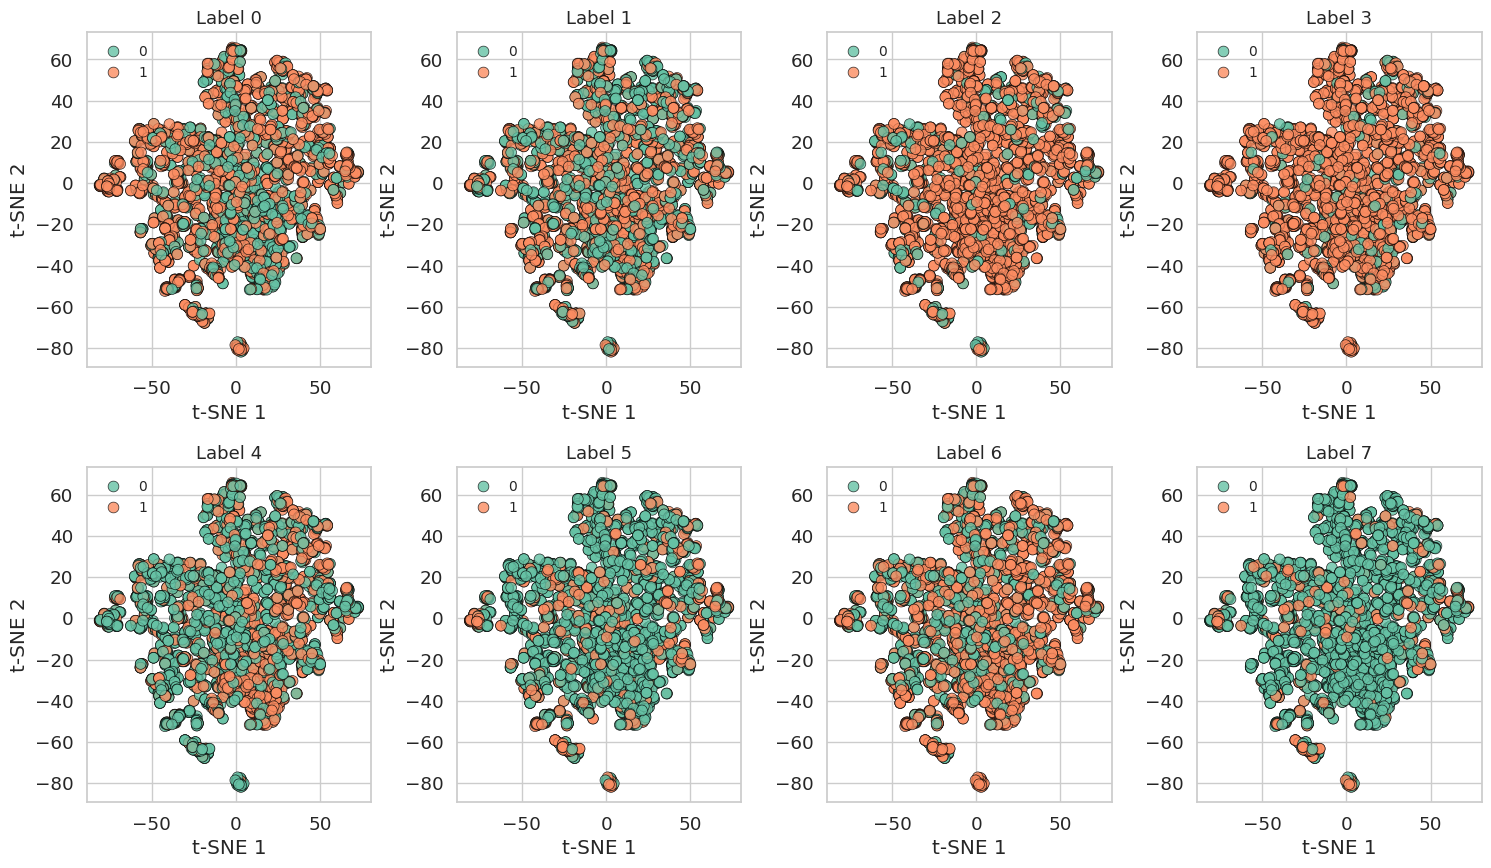

In [24]:
sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("Set2") 

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 4, figure=fig, wspace=0.3, hspace=0.3)

index = 0
for i in range(2):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        scatter = sns.scatterplot(
            data=df_tsne_compounds,
            x="t-SNE 1",
            y="t-SNE 2",
            hue=f"label_{index}",
            palette=palette,
            edgecolor="black",
            linewidth=0.5,
            s=60,
            alpha=0.8,
            ax=ax
        )
        ax.set_title(f"Label {index}", fontsize=13)
        ax.legend(loc='best', frameon=False, fontsize=10)
        ax.set_xlabel("t-SNE 1")
        ax.set_ylabel("t-SNE 2")
        index += 1

plt.tight_layout()
plt.show()

- Making clustering of chemical compounds

In [25]:
with open('../config/hyperparameter_unsupervised_methods.json', 'r') as config:
    hyperparameter_configs = json.load(config)

In [26]:
list_configs = [
    (AgglomerativeClustering, "AgglomerativeClustering", hyperparameter_configs['AgglomerativeClustering']),
    (HDBSCAN, "HDBSCAN", hyperparameter_configs['HDBSCAN']),
    (OPTICS, "OPTICS", hyperparameter_configs['OPTICS']),
    (SpectralClustering, "SpectralClustering", hyperparameter_configs['SpectralClustering']),
    (MeanShift, "MeanShift", hyperparameter_configs['MeanShift']),
    (BisectingKMeans, "BisectingKMeans", hyperparameter_configs['BisectingKMeans']),
    (Birch, "Birch", hyperparameter_configs['Birch']),
    (KMeans, "Kmeans", hyperparameter_configs['Kmeans']),
    (DBSCAN, "DBSCAN", hyperparameter_configs['DBSCAN']),
    (AffinityPropagation, "AffinityPropagation", hyperparameter_configs['AffinityPropagation']),
]

In [27]:
list_models = {}
list_performances = []

for config_values in list_configs:
    model, performances = apply_clustering(
        config_values[0], 
        embeddings, 
        config_values[1], 
        **config_values[2])
    
    list_models.update({config_values[1]: model})
    list_performances.append(performances)

performance_algorithms = pd.DataFrame(list_performances)
performance_algorithms

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,name_method,silhouette_score,davies_bouldin_score,calinski_harabasz_score
0,AgglomerativeClustering,0.093985,2.298561,289.831415
1,HDBSCAN,-0.012814,1.324880,19.433933
2,OPTICS,-0.068552,1.261914,13.648916
3,SpectralClustering,0.448988,0.424977,5.233596
4,MeanShift,0.234456,1.233579,6.109048
5,BisectingKMeans,0.096087,2.296937,311.630745
6,Birch,0.126932,2.145121,430.938749
7,Kmeans,0.113722,2.074858,341.505156
8,DBSCAN,-0.127248,1.334116,3.910363
9,AffinityPropagation,0.211453,1.530667,55.003389


In [30]:
performance_algorithms.sort_values(by="silhouette_score", ascending=False)

,name_method,silhouette_score,davies_bouldin_score,calinski_harabasz_score
3,SpectralClustering,0.448988,0.424977,5.233596
4,MeanShift,0.234456,1.233579,6.109048
9,AffinityPropagation,0.211453,1.530667,55.003389
6,Birch,0.126932,2.145121,430.938749
7,Kmeans,0.113722,2.074858,341.505156
5,BisectingKMeans,0.096087,2.296937,311.630745
0,AgglomerativeClustering,0.093985,2.298561,289.831415
1,HDBSCAN,-0.012814,1.324880,19.433933
2,OPTICS,-0.068552,1.261914,13.648916
8,DBSCAN,-0.127248,1.334116,3.910363


In [45]:
pd.Series(list_models['HDBSCAN'].labels_).value_counts()

-1      1750
 110      52
 1        38
 147      33
 114      27
        ... 
 63        5
 13        5
 108       5
 148       5
 95        5
Name: count, Length: 166, dtype: int64

In [37]:
pd.Series(list_models['AgglomerativeClustering'].labels_).value_counts()

2    716
1    620
0    531
3    508
5    467
4    280
7    190
6    112
Name: count, dtype: int64

In [35]:
pd.Series(list_models['Kmeans'].labels_).value_counts()

4    675
2    525
3    510
1    479
6    416
5    402
0    334
7     83
Name: count, dtype: int64

In [46]:
df_tsne_compounds["Kmeans"] = list_models['Kmeans'].labels_
df_tsne_compounds["AgglomerativeClustering"] = list_models['AgglomerativeClustering'].labels_
df_tsne_compounds["Birch"] = list_models['Birch'].labels_
df_tsne_compounds["BisectingKMeans"] = list_models['BisectingKMeans'].labels_
df_tsne_compounds["AffinityPropagation"] = list_models['AffinityPropagation'].labels_
df_tsne_compounds["HDBSCAN"] = list_models['HDBSCAN'].labels_
df_tsne_compounds["SpectralClustering"] = list_models['SpectralClustering'].labels_
df_tsne_compounds["DBSCAN"] = list_models['DBSCAN'].labels_


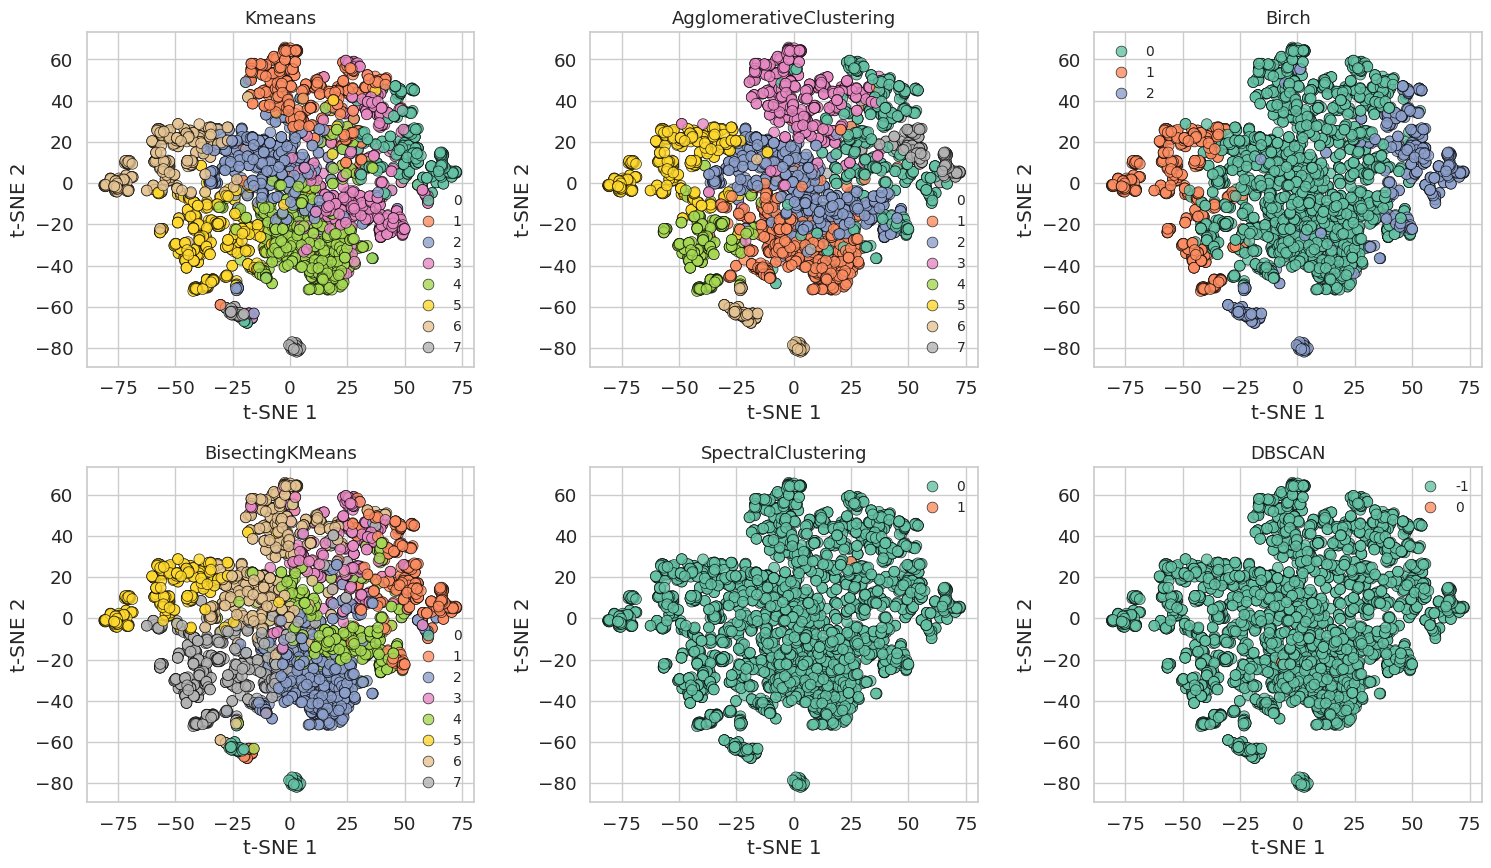

In [49]:
sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("Set2") 

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 3, figure=fig, wspace=0.3, hspace=0.3)

labels = ["Kmeans", "AgglomerativeClustering", "Birch", "BisectingKMeans",
          'SpectralClustering', 'DBSCAN']
index = 0
for i in range(2):
    for j in range(3):
        ax = fig.add_subplot(gs[i, j])
        scatter = sns.scatterplot(
            data=df_tsne_compounds,
            x="t-SNE 1",
            y="t-SNE 2",
            hue=labels[index],
            palette=palette,
            edgecolor="black",
            linewidth=0.5,
            s=60,
            alpha=0.8,
            ax=ax
        )
        ax.set_title(labels[index], fontsize=13)
        ax.legend(loc='best', frameon=False, fontsize=10)
        ax.set_xlabel("t-SNE 1")
        ax.set_ylabel("t-SNE 2")
        index += 1

plt.tight_layout()
plt.show()

In [52]:
for cluster in ["Kmeans", "AgglomerativeClustering", "Birch", "BisectingKMeans",
          'SpectralClustering', 'DBSCAN']:
    df_pivote[cluster] = df_tsne_compounds[cluster].values

In [53]:
df_pivote.to_csv("../pivote_data_with_clusters_compounds.csv", index=False)